In [ ]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Importation des modules internes du projet
from src.analysis.derivation.methodes import Derivation
from src.data import DataPipeline

In [3]:
pipeline_fr = DataPipeline(country="France")
df_fr = pipeline_fr.run()

# Fetch data for Italy
pipeline_it = DataPipeline(country="Italy")
df_it = pipeline_it.run()

### Question c

In [4]:
derivee_I = Derivation(df=df_fr, col="I", h=1)
df_fr["dI_dt"] = derivee_I.premier_derivation_5point()

# Recherche du changement de signe de la dérivée
point_inflexion = df_fr[df_fr['dI_dt'] < 0]

if not point_inflexion.empty:
    # The first row where dI_dt < 0 is the inflection point
    tc = point_inflexion.iloc[0]['date']
    print(f"Le pic épidémique survient autour de {tc}")
else:
    print("Aucun pic détecté dans l'intervalle étudié.")

Le pic épidémique survient autour de 2020-01-24 00:00:00


### Question d

In [5]:
# Calculate the derivative for France
derivee_I_fr = Derivation(df=df_fr, col="I", h=1)
df_fr["dI_dt"] = derivee_I_fr.premier_derivation_5point()

# Calculate the derivative for Italy
derivee_I_it = Derivation(df=df_it, col="I", h=1)
df_it["dI_dt"] = derivee_I_it.premier_derivation_5point()

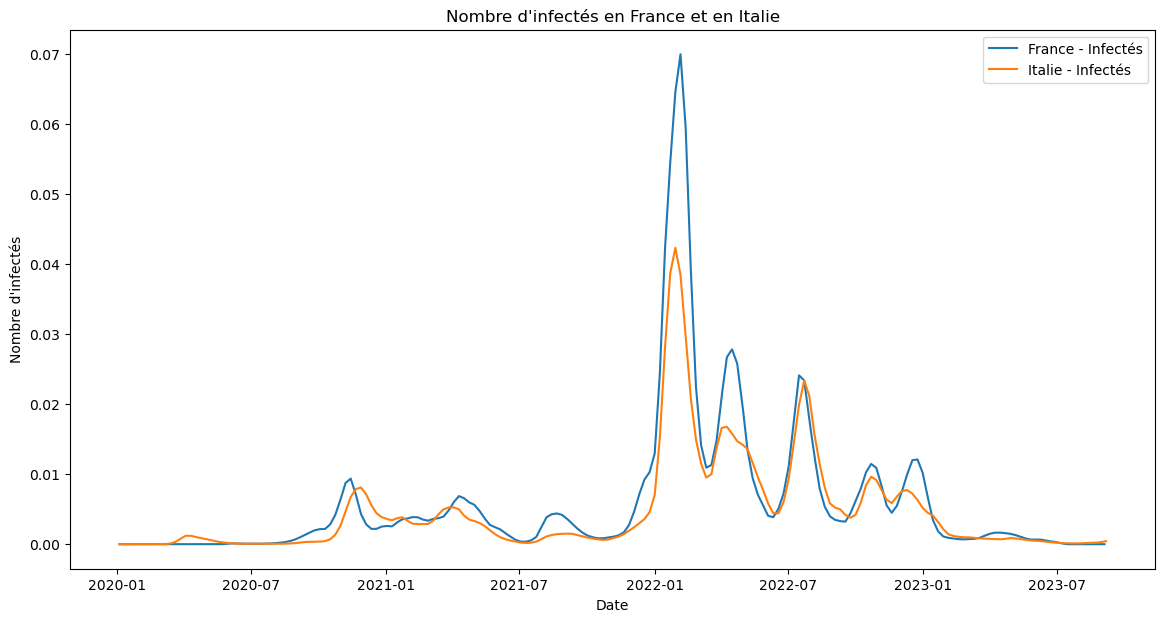

In [6]:
# Plot the number of infected individuals
plt.figure(figsize=(14, 7))
plt.plot(df_fr['date'], df_fr['I'], label='France - Infectés')
plt.plot(df_it['date'], df_it['I'], label='Italie - Infectés')
plt.xlabel('Date')
plt.ylabel('Nombre d\'infectés')
plt.title('Nombre d\'infectés en France et en Italie')
plt.legend()
plt.show()

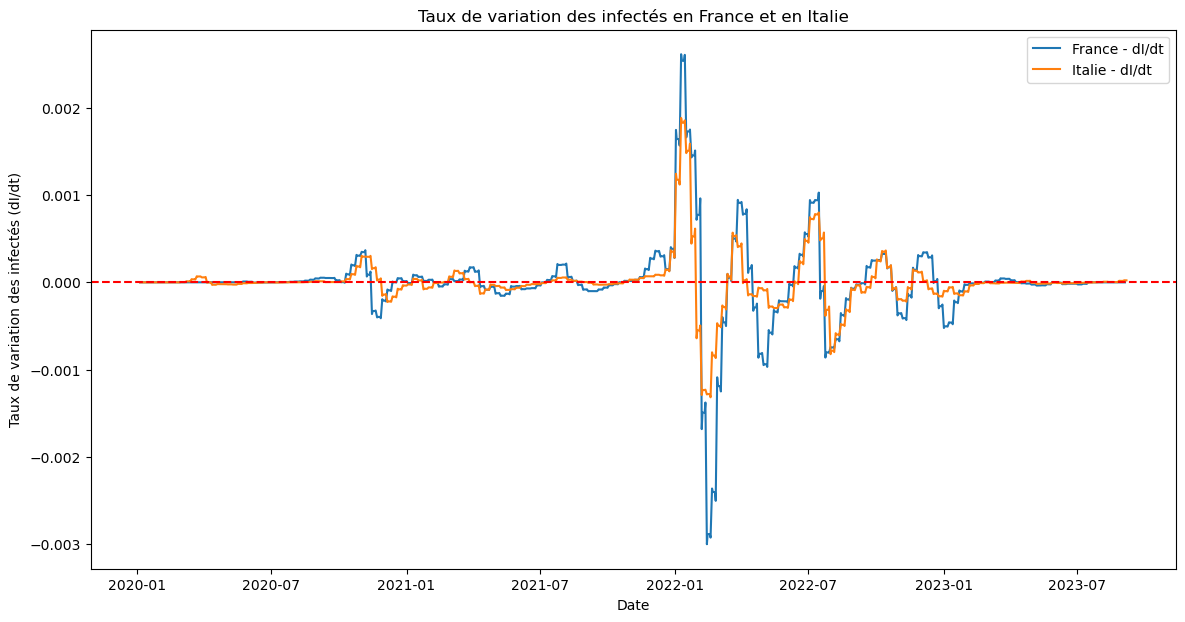

In [7]:
# Plot the derivatives
plt.figure(figsize=(14, 7))
plt.plot(df_fr['date'], df_fr['dI_dt'], label='France - dI/dt')
plt.plot(df_it['date'], df_it['dI_dt'], label='Italie - dI/dt')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Taux de variation des infectés (dI/dt)')
plt.title('Taux de variation des infectés en France et en Italie')
plt.legend()
plt.show()

In [8]:
# Identify the inflection points
inflection_point_fr = df_fr[df_fr['dI_dt'] < 0]
inflection_point_it = df_it[df_it['dI_dt'] < 0]

if not inflection_point_fr.empty:
    tc_fr = inflection_point_fr.iloc[0]['date']
    print(f"Le pic épidémique en France survient autour de {tc_fr}")
else:
    print("Aucun pic détecté en France dans l'intervalle étudié.")

if not inflection_point_it.empty:
    tc_it = inflection_point_it.iloc[0]['date']
    print(f"Le pic épidémique en Italie survient autour de {tc_it}")
else:
    print("Aucun pic détecté en Italie dans l'intervalle étudié.")

Le pic épidémique en France survient autour de 2020-01-24 00:00:00
Le pic épidémique en Italie survient autour de 2020-01-31 00:00:00


### Question e

In [9]:
# Calculate the derivatives using numerical differentiation
# For S (susceptibles)
derivee_S = Derivation(df=df_fr, col="S", h=1)
df_fr["dS_dt"] = derivee_S.premier_derivation_5point()

# For R (recovered)
derivee_R = Derivation(df=df_fr, col="R", h=1)
df_fr["dR_dt"] = derivee_R.premier_derivation_5point()

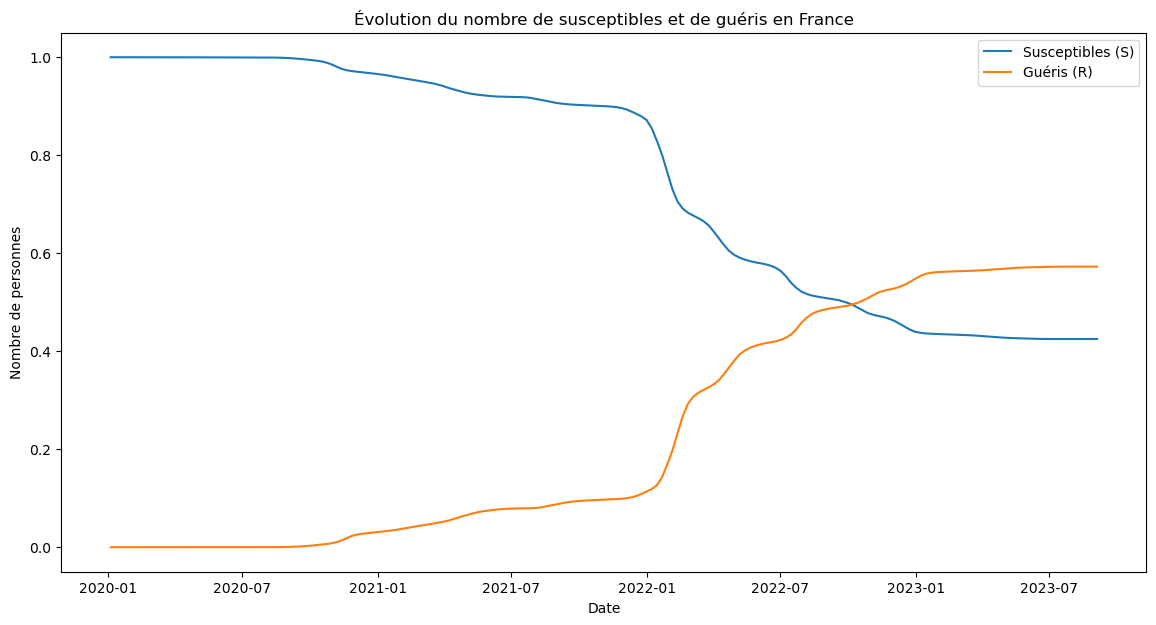

In [10]:
# Plot the number of susceptibles and recovered over time
plt.figure(figsize=(14, 7))
plt.plot(df_fr['date'], df_fr['S'], label='Susceptibles (S)')
plt.plot(df_fr['date'], df_fr['R'], label='Guéris (R)')
plt.xlabel('Date')
plt.ylabel('Nombre de personnes')
plt.title('Évolution du nombre de susceptibles et de guéris en France')
plt.legend()
plt.show()

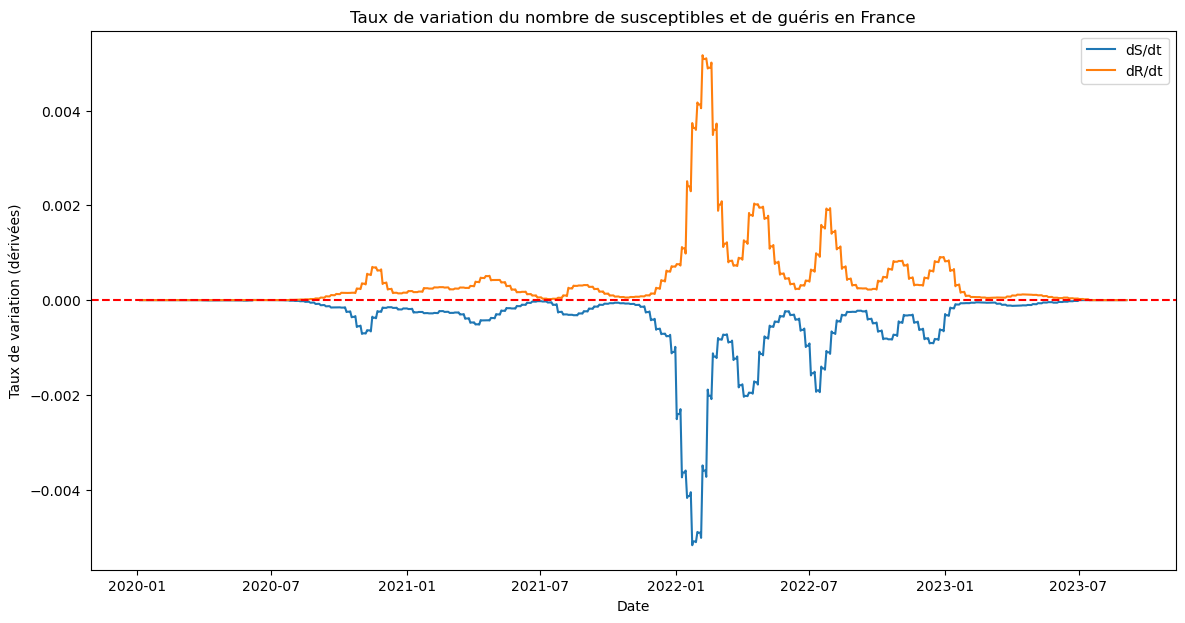

In [11]:
# Plot the derivatives
plt.figure(figsize=(14, 7))
plt.plot(df_fr['date'], df_fr['dS_dt'], label='dS/dt')
plt.plot(df_fr['date'], df_fr['dR_dt'], label='dR/dt')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Taux de variation (dérivées)')
plt.title('Taux de variation du nombre de susceptibles et de guéris en France')
plt.legend()
plt.show()

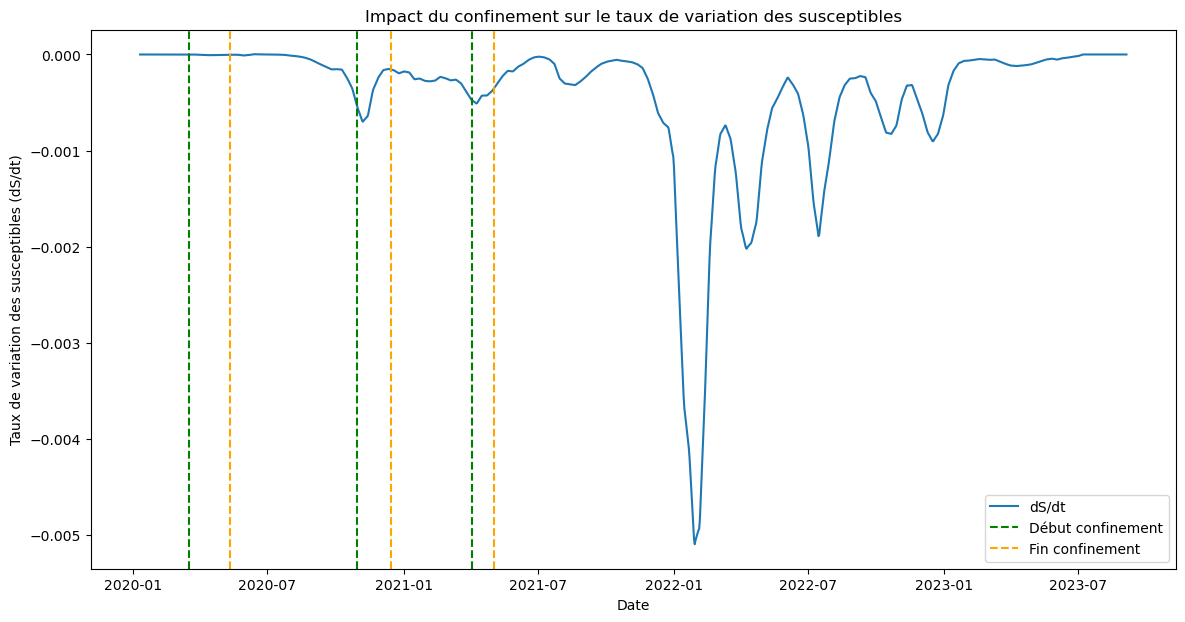

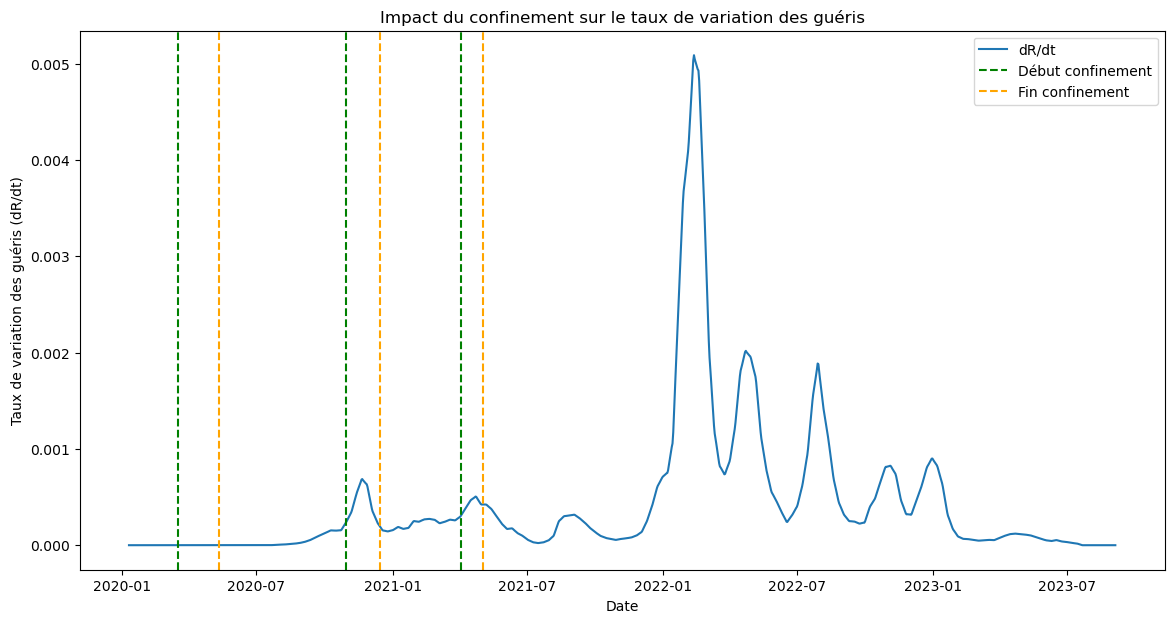

In [12]:
# Analyse de l'impact des mesures sanitaires
# Liste des périodes de confinement en France
confinements = [
    {'start': '2020-03-17', 'end': '2020-05-11'},
    {'start': '2020-10-30', 'end': '2020-12-15'},
    {'start': '2021-04-03', 'end': '2021-05-03'},
]
df_fr['dS_dt'] = df_fr['dS_dt'].rolling(window=7).mean()
df_fr['dR_dt'] = df_fr['dR_dt'].rolling(window=7).mean()

# Convertir en datetime
for c in confinements:
    c['start'] = pd.to_datetime(c['start'])
    c['end'] = pd.to_datetime(c['end'])

# Graphique dS/dt
plt.figure(figsize=(14, 7))
plt.plot(df_fr['date'], df_fr['dS_dt'], label='dS/dt')

for i, c in enumerate(confinements):
    plt.axvline(c['start'], color='green', linestyle='--', label='Début confinement' if i == 0 else "")
    plt.axvline(c['end'], color='orange', linestyle='--', label='Fin confinement' if i == 0 else "")
plt.xlabel('Date')
plt.ylabel('Taux de variation des susceptibles (dS/dt)')
plt.title('Impact du confinement sur le taux de variation des susceptibles')
plt.legend()
plt.show()

# Graphique dR/dt
plt.figure(figsize=(14, 7))
plt.plot(df_fr['date'], df_fr['dR_dt'], label='dR/dt')
for i, c in enumerate(confinements):
    plt.axvline(c['start'], color='green', linestyle='--', label='Début confinement' if i == 0 else "")
    plt.axvline(c['end'], color='orange', linestyle='--', label='Fin confinement' if i == 0 else "")

plt.xlabel('Date')
plt.ylabel('Taux de variation des guéris (dR/dt)')
plt.title('Impact du confinement sur le taux de variation des guéris')
plt.legend()
plt.show()